In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $\mu$, $A$ and $\omega$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x}_0 = \mu x_0 - x_1 - \mu x_0 x_1^2 + A\sin(\omega x_1^2) \\
\dot{x}_1 = x_0
\end{cases}
$$
and with $\mu=1$, $A=1$ and $\omega=1$ fixed.

In [2]:
# Select ODE & settings:
ode_name = 'OscilVdpODE' # help="name of the ode", type=str
ode_param = None # '1.,1.,1.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 103 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [ ]:
# running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=103, n_seed=1
Dataset shape:  (101, 50, 2)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.03       4.0901e+07        9           0.7238         0.656697      3.98m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.60           316.73        9         0.716019          0.72672      4.51m
   2     4.85          72.5427       10         0.665144         0.598558      4.32m
   3     5.91          15983.2       11         0.592381         0.632758      3.04m
   4     6.34          9806.75       11         0.589751         0.656432      2.93m
   5     6.57          9955.67       13         0.458175         0.495218      2.84m
   6     6.71          96.2385       14         0.431276         0.426834      2.59m
   7     7.93          256.314       14         0.394269         0.406683      2.50m
   8     9.85          324.154       14         0.369858          0.39438      2.27m
   9    10.66          127.124       15         0.273418         0.261329      2.89m
  10    11.27          54.5198       13         0.264202         0.234347      2.56m
  11    12.42          9998.12       17         0.203912         0.217667      1.57m
  12    13.24          194.903       14         0.102693         

In [3]:
from scipy.integrate import solve_ivp
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f  # la funzione dinamica, es. f = lambda z,t: [z[1], -np.sin(z[0])]
    
    def simulate(self, x0, t, u=None):
        # u ignorato, lo metti solo per compatibilità con SINDy
        sol = solve_ivp(lambda t, z: self.f(z, t), [t[0], t[-1]], x0, t_eval=t, vectorized=False)
        return sol.y.T  # restituisce shape (len(t), dim_x)
    
f = lambda x, t: [x[0]*(0.9999316180527035 - x[1]**2) - x[1] + np.sin(x[1]**2), 
                  x[0]]
model = SRModel(f)


In [4]:
import matplotlib.pyplot as plt
import numpy as np


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t[:T_plot],
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t[:T_plot]
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]

    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$t$")
            ax.set_ylabel(r"$x(t)$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9, frameon=False, loc='lower right')

            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 (PHASE SPACE) ----------
        elif dim_x == 2:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4.3))

            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0], xt_true[:, 1],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$x_1$")
            ax.set_ylabel(r"$x_2$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(
            fontsize=9,
            loc='lower right',
            frameon=True,
            framealpha=0.8,
            facecolor='white',
            edgecolor='0.8'
            )


            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.set_zlabel(r"$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()


SR_T Model RMSE:  0.00718860626453847


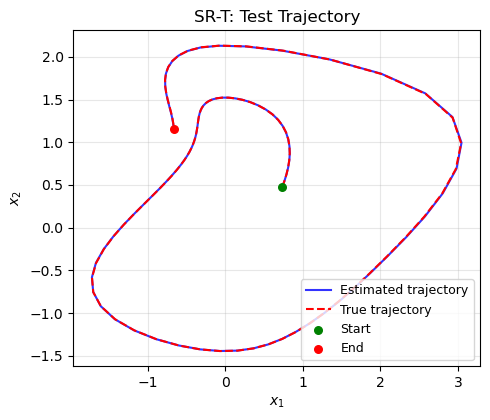

In [5]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [1., 1.], [0., 0.], dim_k)
print('SR_T Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.7, 0.4]
title = 'SR-T: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

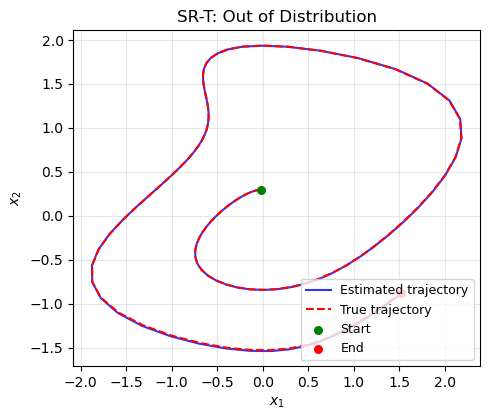

In [6]:
evaluate_sample = 1
ics = [0.0, 0.3]
title = 'SR-T: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

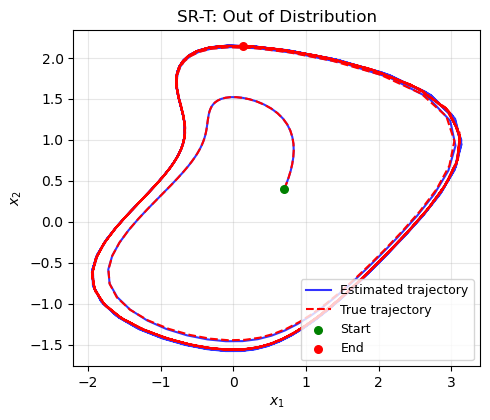

In [7]:
evaluate_sample = 1
ics = [0.7, 0.4]
title = 'SR-T: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=40)

In [3]:
# running D-CODE
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)
# building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=OscilVdpODE, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=103, n_seed=1
Dataset shape:  (201, 50, 2)
Functions set:  {'neg': 1, 'mul': 1, 'add': 1, 'sub': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.03      9.23078e+21        9          124.183          123.216      4.07m
   1     5.11      1.95279e+11        6            118.2          116.958      3.21m
   2     3.28       1.6673e+10       11          102.383           117.88      2.95m
 
promising programs:
add(sub(mul(neg(sub(cos(4.388), neg(X1))), X0), X1), sin(pow(X1, 1.820)))
sub(mul(sub(cos(sub(cos(X1), X1)), X1), X0), X1)
sub(mul(cos(pow(X1, 1.648)), X0), X1)
sub(mul(cos(pow(X1, 1.648)), X0), X1)
add(sin(pow(X1, 1.829)), sub(neg(X1), mul(

In [8]:
from scipy.integrate import solve_ivp
import numpy as np

class FuncModel:
    def __init__(self, f):
        self.f = f  # la funzione dinamica, es. f = lambda z,t: [z[1], -np.sin(z[0])]
    
    def simulate(self, x0, t, u=None):
        # u ignorato, lo metti solo per compatibilità con SINDy
        sol = solve_ivp(lambda t, z: self.f(z, t), [t[0], t[-1]], x0, t_eval=t, vectorized=False)
        return sol.y.T  # restituisce shape (len(t), dim_x)
    
def f(x, t):
    x = np.asarray(x).ravel()
    return np.array([
        x[0]*np.cos(1.7301545306005086*x[1]) - x[1] + np.sin(x[1]**2),
        x[0]
    ], dtype=float)


model = FuncModel(f)


In [9]:
import matplotlib.pyplot as plt
import numpy as np


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t[:T_plot],
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t[:T_plot]
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]

    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$t$")
            ax.set_ylabel(r"$x(t)$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=9, frameon=False, loc='lower right')

            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 (PHASE SPACE) ----------
        elif dim_x == 2:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4.3))

            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0], xt_true[:, 1],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel(r"$x_1$")
            ax.set_ylabel(r"$x_2$")

            if title:
                ax.set_title(title)

            ax.grid(True, alpha=0.3)
            ax.legend(
            fontsize=9,
            loc='lower right',
            frameon=True,
            framealpha=0.8,
            facecolor='white',
            edgecolor='0.8'
            )


            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel(r"$x$")
            ax.set_ylabel(r"$y$")
            ax.set_zlabel(r"$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()


D-CODE Model RMSE:  0.27693719187340093


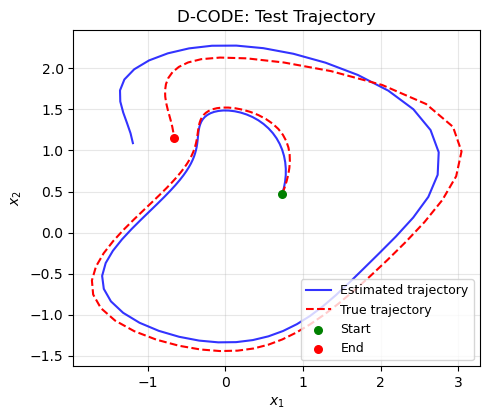

In [10]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [1., 1.], [0., 0.], dim_k)
print('D-CODE Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.7, 0.4]
title = 'D-CODE: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

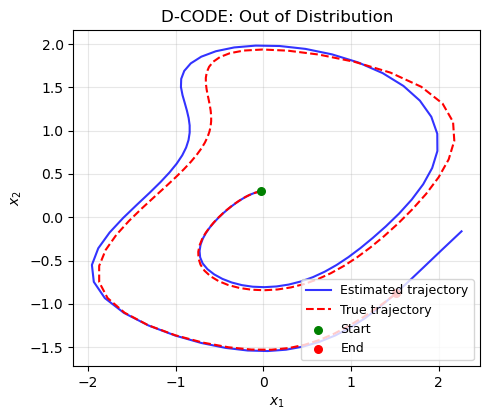

In [11]:
evaluate_sample = 1
ics = [0.0, 0.3]
title = 'D-CODE: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=10)

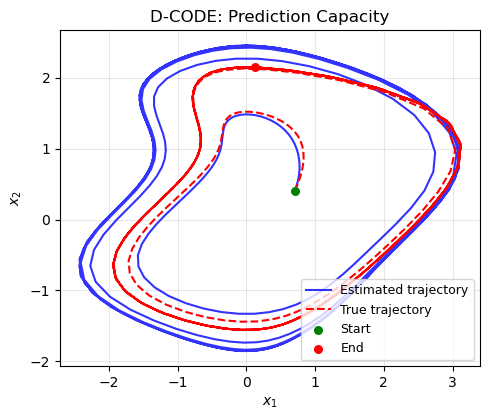

In [12]:
evaluate_sample = 1
ics = [0.7, 0.4]
title = 'D-CODE: Prediction Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=40)